# General Note
In order to guide you through the homework, we put "...COMPLETE HERE..." as placeholder for you to complete the homework.

In [1]:
%matplotlib inline


# Classifying Names with a Character-Level RNN

We will biuld and train a character-level *Recurrent Neural
Network* (*RNN*) to classify words.

A character-level RNN reads words as a series of characters -
it outputs a prediction and hidden state at each step, and feeds the
previous hidden state into each next step. We take the final prediction
to be the output, that represents which class the word belongs to.

We want to predict the Language class to which belongs the Surnames.

## Preparing the Data

We will create a dictionary of lists of names per language,
``{language: [names ...]}``.


In [2]:
!git clone https://github.com/sarafrr/pytorch-tutorial-nlp-public.git

Cloning into 'pytorch-tutorial-nlp-public'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 100 (delta 39), reused 81 (delta 23), pack-reused 0
Receiving objects: 100% (100/100), 1.55 MiB | 8.52 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
# general import

import os
from glob import glob
from io import open
import string
import numpy as np
import random
import torch
import torch.nn as nn

In [4]:
def getFiles(path):
  return glob(path)

file_list = getFiles('./data/Names/*.txt')
print(file_list[:2])

['./data/Names/Russian.txt', './data/Names/Dutch.txt']


In [5]:
!rm -r pytorch-tutorial-nlp-public/

In [6]:
# read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

print(readLines(file_list[0]))
print(readLines(file_list[1]))

['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin', 'Abaimoff', 'Abaimov', 'Abakeliya', 'Abakovsky', 'Abakshin', 'Abakumoff', 'Abakumov', 'Abakumtsev', 'Abakushin', 'Abalakin', 'Abalakoff', 'Abalakov', 'Abaleshev', 'Abalihin', 'Abalikhin', 'Abalkin', 'Abalmasoff', 'Abalmasov', 'Abaloff', 'Abalov', 'Abamelek', 'Abanin', 'Abankin', 'Abarinoff', 'Abarinov', 'Abasheev', 'Abashev', 'Abashidze', 'Abashin', 'Abashkin', 'Abasov', 'Abatsiev', 'Abaturoff', 'Abaturov', 'Abaza', 'Abaziev', 'Abbakumov', 'Abbakumovsky', 'Abbasov', 'Abdank-Kossovsky', 'Abdeev', 'Abdildin', 'Abdrahimoff', 'Abdrahimov', 'Abdrahmanoff', 'Abdrahmanov', 'Abdrakhimoff', 'Abdrakhimov', 'Abdrakhmanoff', 'Abdrakhmanov', 'Abdrashitoff', 'Abdrashitov', 'Abdrazakoff', 'Abdrazakov', 'Abdulaev', 'Abdulatipoff', 'Abdulatipov', 'Abdulazizoff', 'Abdulazizov', 'Abdulbasiroff', 'Abdulbasirov', 'Abdulbekoff', 'Abdulbekov', 'Abdulgapuroff', 'Abdulgapurov', 'Abdulgaziev', 'Abdulhabiroff', 'Abdulhabirov', 'Abdulin', 'Abdulkadyroff', 

In [7]:
# category_words is a dict with the key as the language
# and the value a list with all the possible names in the specific language
category_words = {}
all_categories = []
alphabet = set()

for filename in file_list:
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    for word in lines:
      alphabet |= set(word)
    category_words[category] = lines

# letter to index
l_to_i = dict(zip(alphabet, range(len(alphabet))))
print(category_words)
n_categories = len(all_categories)
print(f'N. of languages: {n_categories}')
print(l_to_i)
n_letters = len(l_to_i)
print(f'The alphabet has {n_letters} letters')

{'Russian': ['Ababko', 'Abaev', 'Abagyan', 'Abaidulin', 'Abaidullin', 'Abaimoff', 'Abaimov', 'Abakeliya', 'Abakovsky', 'Abakshin', 'Abakumoff', 'Abakumov', 'Abakumtsev', 'Abakushin', 'Abalakin', 'Abalakoff', 'Abalakov', 'Abaleshev', 'Abalihin', 'Abalikhin', 'Abalkin', 'Abalmasoff', 'Abalmasov', 'Abaloff', 'Abalov', 'Abamelek', 'Abanin', 'Abankin', 'Abarinoff', 'Abarinov', 'Abasheev', 'Abashev', 'Abashidze', 'Abashin', 'Abashkin', 'Abasov', 'Abatsiev', 'Abaturoff', 'Abaturov', 'Abaza', 'Abaziev', 'Abbakumov', 'Abbakumovsky', 'Abbasov', 'Abdank-Kossovsky', 'Abdeev', 'Abdildin', 'Abdrahimoff', 'Abdrahimov', 'Abdrahmanoff', 'Abdrahmanov', 'Abdrakhimoff', 'Abdrakhimov', 'Abdrakhmanoff', 'Abdrakhmanov', 'Abdrashitoff', 'Abdrashitov', 'Abdrazakoff', 'Abdrazakov', 'Abdulaev', 'Abdulatipoff', 'Abdulatipov', 'Abdulazizoff', 'Abdulazizov', 'Abdulbasiroff', 'Abdulbasirov', 'Abdulbekoff', 'Abdulbekov', 'Abdulgapuroff', 'Abdulgapurov', 'Abdulgaziev', 'Abdulhabiroff', 'Abdulhabirov', 'Abdulin', 'Abdu

In [8]:
# this is all the necessary code to set the seed
def set_seed(seed : int = 123):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

In [9]:
set_seed()

### Turning Names into Tensors

As always, we have to convert textual data into tensors.

To represent a single letter, we use a "one-hot vector" of size
``(1 x n_letters)``, where 1 is the respective index of the letter it is representing.

To make a word we combine a bunch of those representations into a 2D matrix
``(word_length x 1 x n_letters)``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here, for the sake of simplicity.




# Question 1
Create the auxiliary function to process the data to have the input suitable for `nn.Embedding`. This is because one of the following questions will be to try not to use one-hot-encoding representation, but use the embedding layer instead.

In [10]:
def letterToIndex(letter):
  '''
  Returns the index of a letter in the alphabet
  '''
  return l_to_i[letter]

def wordToOneHotTensor(word):
  '''
  Returns the word in zero-hot encoding
  '''
  tensor = torch.zeros(len(word), 1, n_letters).long()
  for idx, let in enumerate(word):
      tensor[idx][0][letterToIndex(let)] = 1
  return tensor

def wordToEmbedding(word):
  indexes = [letterToIndex(letter) for letter in word]
  return torch.tensor(indexes, dtype=torch.long)

tmp = 'Aarle'

print(f'N. of letters {len(alphabet)}')
print(f'Length of the word {len(tmp)}\n')
print(wordToOneHotTensor(tmp).size())
print(wordToOneHotTensor(tmp))
print('\n')
print(wordToEmbedding(tmp).size())
print(wordToEmbedding(tmp))

N. of letters 87
Length of the word 5

torch.Size([5, 1, 87])
tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]],

        [[0, 0, 0, 0, 0, 0

# Question 2
Implement the Vanilla RNN considering a batch size of dimension 1 (the simplest case).

## Creating the Network

Here, we are going to create RNNs with one only layer for the sake of simplicity. However, these models can be easily expanded to the more general case of having more layers.  

The Vanilla RNN is just 2 linear layers which operate on an input and hidden state.




In [11]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNN, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    combined = torch.cat((input, hidden), 1)
    hidden = self.i2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

In [12]:
class RNNEmb(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, type_layer):
    super(RNNEmb, self).__init__()

    self.hidden_size = hidden_size
    self.type_layer = type_layer

    self.embedding = nn.Embedding(input_size, hidden_size)

    self.e2h = nn.Linear(hidden_size + hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)


  def forward(self, input, hidden):
    embedded = self.embedding(input)
    combined = torch.cat((torch.unsqueeze(embedded, 0), hidden), 1)
    hidden = self.e2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden

  def initHidden(self):
    return torch.zeros(1, self.hidden_size)

# Question 3
Implement an LSTM cell considering a batch size of dimension 1 (the simplest case).

In [34]:
class LSTM(torch.nn.Module):

    def __init__(self, input_length, hidden_length, output_length, type_layer):
        super(LSTM, self).__init__()

        self.input_length = input_length
        self.hidden_length = hidden_length
        self.output_length = output_length
        self.type_layer = type_layer

        # forget gate components
        self.linear_forget_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_forget = nn.Sigmoid()

        # input gate components
        self.linear_input_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.linear_input_w2 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_input = nn.Sigmoid()
        self.tanh_input = nn.Tanh()

        # out gate components
        self.linear_output_w1 = nn.Linear(self.input_length + self.hidden_length, self.hidden_length, bias=True)
        self.sigmoid_out = nn.Sigmoid()

        self.linear_output_final = nn.Linear(self.hidden_length, self.output_length, bias=True)
        self.activation_final = nn.Tanh()
        self.log_softmax = nn.LogSoftmax(dim=1)


    def forget(self, x, h):
        #print('forget',torch.cat((x, h), dim=1).shape)
        ret = self.linear_forget_w1(torch.cat((x, h), dim=1))
        return self.sigmoid_forget(ret)


    def input_gate(self, x, h):
        # input gate
        i_t = self.linear_input_w1(torch.cat((x, h), dim=1))
        C_t = self.linear_input_w2(torch.cat((x, h), dim=1))
        return self.sigmoid_input(i_t), self.tanh_input(C_t)


    def out_gate(self, x, h):
        ret = self.linear_output_w1(torch.cat((x, h), dim=1))
        return self.sigmoid_out(ret)


    def forward(self, x, tuple_in):
        x = x.to(torch.float32)
        (h, c_prev) = tuple_in

        # forge gate
        f_t = self.forget(x, h)

        # input gate
        i_t, c_t = self.input_gate(x, h)

        # updating the cell memory
        c_next = (c_prev * f_t) + (i_t * c_t)
        #self.c_next = c_next

        # calculate the main output gate
        o = self.out_gate(x, h)

        # produce next hidden output
        #print('output', (o * self.activation_final(c_next)).shape)
        h_next = o * self.activation_final(c_next)

        return self.log_softmax(self.linear_output_final(h_next)), (h_next, c_next)


    def initHidden(self):
        return (torch.zeros(1, self.hidden_length).to(torch.float32), torch.zeros(1, self.hidden_length).to(torch.float32))

In [ ]:
'''class LSTM2(torch.nn.Module):


    def __init__(self, input_length, hidden_length, type_layer):
        super(LSTM2, self).__init__()

        self.input_length = input_length
        self.hidden_length = hidden_length
        self.type_layer = type_layer

        # forget gate components
        self.linear_forget_w1 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_forget_r1 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_forget = nn.Sigmoid()

        # input gate components
        self.linear_gate_w2 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r2 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_gate = nn.Sigmoid()

        # cell memory components
        self.linear_gate_w3 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r3 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.activation_gate = nn.Tanh()

        # out gate components
        self.linear_gate_w4 = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_gate_r4 = nn.Linear(self.hidden_length, self.hidden_length, bias=False)
        self.sigmoid_hidden_out = nn.Sigmoid()

        self.activation_final = nn.Tanh()
        self.log_softmax = nn.LogSoftmax(dim=1)


    def forget(self, x, h):
        x = self.linear_forget_w1(x)
        h = self.linear_forget_r1(h)
        return self.sigmoid_forget(x + h)


    def input_gate(self, x, h):
        # Equation 1. input gate
        x_temp = self.linear_gate_w2(x)
        h_temp = self.linear_gate_r2(h)
        i = self.sigmoid_gate(x_temp + h_temp)
        return i


    def cell_memory_gate(self, i, f, x, h, c_prev):
        x = self.linear_gate_w3(x)
        h = self.linear_gate_r3(h)

        # new information part that will be injected in the new context
        k = self.activation_gate(x + h)
        g = k * i

        # forget old context/cell info
        c = f * c_prev
        # learn new context/cell info
        c_next = g + c
        return c_next


    def out_gate(self, x, h):
        x = self.linear_gate_w4(x)
        h = self.linear_gate_r4(h)
        return self.sigmoid_hidden_out(x + h)


    def forward(self, x, tuple_in):
        x = x.to(torch.float32)

        (h, c_prev) = tuple_in
        # Equation 1. input gate
        i = self.input_gate(x, h)

        # Equation 2. forget gate
        f = self.forget(x, h)

        # Equation 3. updating the cell memory
        c_next = self.cell_memory_gate(i, f, x, h, c_prev)
        self.c_next = c_next

        # Equation 4. calculate the main output gate
        o = self.out_gate(x, h)

        # Equation 5. produce next hidden output
        h_next = o * self.activation_final(c_next)
        self.h_next = h_next

        return self.log_softmax(o), (h_next, c_next)


    def initHidden(self):
        return (torch.zeros(1, self.hidden_length).to(torch.float32), torch.zeros(1, self.hidden_length).to(torch.float32))'''

## Training
Preparing for Training
----------------------

The output of the network is a likelihood of each category. Use ``Tensor.topk`` to get the index
of the greatest value:




In [14]:
def categoryFromOutput(output):
    top_val, top_idx = output.topk(1)
    # print(top_val)
    # print(top_idx)
    category_idx = top_idx[0].item()
    return all_categories[category_idx], category_idx

We will also want a quick way to get a training example (a name and its
language):




In [15]:
print(all_categories)

['Russian', 'Dutch', 'Japanese', 'Arabic', 'Chinese', 'Vietnamese', 'Italian', 'Korean', 'Polish', 'Czech', 'German', 'Greek', 'Irish', 'Spanish', 'English', 'French', 'Portuguese', 'Scottish']


# Related to Question 1
In order to use the embeddings in place of one-hot-encoded representation, you should modify also the function `randomChoice()` in the following snippet of code to have the correct input data.

In [16]:
import random

def randomChoice(l):
  '''
  Returns a random integer given the list of languages
  '''
  return l[random.randint(0, len(l) - 1)]

def randomTrainingExample(model):
    category = randomChoice(all_categories)
    word = randomChoice(category_words[category])
    # create a long tensor with the index of the language
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)

    if model == 'linear': word_tensor = wordToOneHotTensor(word)
    else: word_tensor = wordToEmbedding(word)

    return category, word, category_tensor, word_tensor

for ty in ['embeds', 'linear']:
  for i in range(4):
    category, word, category_tensor, word_tensor = randomTrainingExample(ty)
    print('category =', category, '\n word =', word, '\n category_tensor =', category_tensor, '\n word_tensor =', word_tensor, '\n len word_tensor =', word_tensor.size())
    print('\n')

category = Dutch 
 word = Meeuweszen 
 category_tensor = tensor([1]) 
 word_tensor = tensor([73, 13, 13, 24, 43, 13, 17, 39, 13, 48]) 
 len word_tensor = torch.Size([10])


category = Japanese 
 word = Sugitani 
 category_tensor = tensor([2]) 
 word_tensor = tensor([10, 24, 41, 53, 31, 77, 48, 53]) 
 len word_tensor = torch.Size([8])


category = Spanish 
 word = Ibarra 
 category_tensor = tensor([13]) 
 word_tensor = tensor([81, 82, 77, 86, 86, 77]) 
 len word_tensor = torch.Size([6])


category = Arabic 
 word = Assaf 
 category_tensor = tensor([3]) 
 word_tensor = tensor([36, 17, 17, 77, 61]) 
 len word_tensor = torch.Size([5])


category = Dutch 
 word = Reijnder 
 category_tensor = tensor([1]) 
 word_tensor = tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Training the Network
 In the following change the initialisation with the model you want to use.




In [35]:
n_hidden = 128
criterion = nn.NLLLoss()

In [ ]:
rnn = RNN(n_letters, n_hidden, n_categories, 'linear')

In [ ]:
rnn_embeds = RNNEmb(n_letters, n_hidden, n_categories, 'embeds')

In [38]:
lstm = LSTM(n_letters, n_hidden, n_categories, 'linear')

Each loop of training will:

1. Create input and target tensors
2. Read each letter in and keep the hidden state for next letter
3. Compare final output to target
4. Back-propagate
5. Return the output and loss




# Question 3
After having tryied the learning rate which is proposed in the script, `0.005`, use the learning rate equal to `1`. What is happening? Can you explaing why?

VANISHING EXPLODING PROBLEM

What is the quickest way to get rid of the problem? Modify the code trying to implement a possible solution.

GRADEINT CLIPPING

What is the other problem this kind of network has? And what are the possible solutions?

In [19]:
from torch import optim


def train(category_tensor, word_tensor, model, optimizer):
    # If you set this too high, it might explode. If too low, it might not learn
    #learning_rate = 0.005
    #optimizer = optim.SGD(model.parameters(), lr = lr)
    #optimizer = optim.Adam(model.parameters(), lr = learning_rate)


    #h_lstm, h_rnn = None, None
    #h = None

    #if model.__class__.__name__ == "LSTM": h_lstm = model.initHidden()
    #else: h_rnn = model.initHidden()
    h = model.initHidden()

    optimizer.zero_grad()
    # iterate over the word for all the letters in the word
    for i in range(word_tensor.size(0)):
      # modify the following with the correct implementation depending on the
      # network you are using


        #output, h_lstm = model(word_tensor[i], h_lstm)
      #else:
        #output, h_rnn = model(word_tensor[i], h_rnn)
      #print(model.__class__.__name__, word_tensor[i])
      output, h = model(word_tensor[i], h)
      #if model.__class__.__name__ == "LSTM": output = model.log_softmax(output)

    #print(output.size(), category_tensor.size())
    loss = criterion(output, category_tensor)
    loss.backward()

    # Gradient clipping using that clips the gradients using a vector norm
    # Clips gradient norm of an iterable of parameters.
    #The norm is computed over all gradients together, as if they were concatenated into a single vector. Gradients are modified in-place.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)

    optimizer.step()
    return output, loss.item()

The ``train`` function returns the output and loss we can print what are its predictions and also to keep track of the loss.
We can choose how many examples print these outputs thanks to ``print_every``.




In [20]:
import time
import math


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s/60)
    s -= m*60
    return '%dm %ds' % (m, s)

def run_training(model, optimizer):
  n_iters = 100000
  print_every = 5000
  plot_every = 1000

  # keep track of losses for plotting
  current_loss = 0
  all_losses = []



  start = time.time()

  for iter in range(1, n_iters + 1):
      category, word, category_tensor, word_tensor = randomTrainingExample(model.type_layer)
      #print(type(category), type(word), category_tensor[0].dtype, word_tensor[0].dtype)

      output, loss = train(category_tensor, word_tensor, model, optimizer)
      current_loss += loss

      if iter % print_every == 0:
          category_pred, category_idx = categoryFromOutput(output)
          correct = 'OK' if category_pred == category else 'NO (%s)' % category
          print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, word, category_pred, correct))

      # add the current loss to the list of losses
      if iter % plot_every == 0:
          all_losses.append(current_loss / plot_every)
          current_loss = 0

  return all_losses

In [ ]:
lr = 0.005
optimizer_rnn = optim.SGD(rnn.parameters(), lr = lr)
#optimizer_rnn = optim.Adam(rnn.parameters(), lr = lr)

rnn_losses = run_training(rnn, optimizer_rnn)

5000 5% (0m 8s) 2.8036 Dam / Arabic NO (Vietnamese)
10000 10% (0m 17s) 2.5309 Jedlicka / Polish NO (Czech)
15000 15% (0m 24s) 1.8494 Seok / Korean OK
20000 20% (0m 33s) 1.2370 Suk / Korean OK
25000 25% (0m 43s) 3.2421 Salazar / Scottish NO (Spanish)
30000 30% (0m 50s) 1.8970 Kalihman / Scottish NO (Russian)
35000 35% (0m 59s) 1.9009 Rosario / Greek NO (Portuguese)
40000 40% (1m 7s) 3.2926 Banderas / Greek NO (Spanish)
45000 45% (1m 15s) 0.8528 Pho / Vietnamese OK
50000 50% (1m 23s) 2.3628 Hruskova / Italian NO (Czech)
55000 55% (1m 32s) 2.7522 Daly / Chinese NO (English)
60000 60% (1m 40s) 1.5865 Ariwa / Japanese OK
65000 65% (1m 48s) 1.5157 Salib / Arabic OK
70000 70% (1m 56s) 1.8122 Han / Chinese NO (Korean)
75000 75% (2m 4s) 1.7862 Sabbagh / Irish NO (Arabic)
80000 80% (2m 12s) 0.8757 Vo / Vietnamese OK
85000 85% (2m 21s) 2.1662 Karl / Arabic NO (German)
90000 90% (2m 29s) 2.8121 Santiago / Italian NO (Portuguese)
95000 95% (2m 37s) 0.8628 Ebner / German OK
100000 100% (2m 46s) 1.75

In [ ]:
lr = 0.005
optimizer_rnn_embeds = optim.SGD(rnn_embeds.parameters(), lr = lr)
#optimizer_rnn_embeds = optim.Adam(rnn_embeds.parameters(), lr = lr)

rnn_embeds_losses = run_training(rnn_embeds, optimizer_rnn_embeds)

5000 5% (0m 9s) 2.5212 Kattan / Irish NO (Arabic)
10000 10% (0m 19s) 1.3377 Sokal / Polish OK
15000 15% (0m 29s) 1.6240 Jong / Chinese NO (Korean)
20000 20% (0m 39s) 0.4579 Böttcher / German OK
25000 25% (0m 49s) 3.1795 Geyer / German NO (English)
30000 30% (0m 59s) 2.0402 Abel / Dutch NO (Spanish)
35000 35% (1m 8s) 3.3102 Waldvogel / Czech NO (German)
40000 40% (1m 18s) 2.7479 Basurto / Portuguese NO (Spanish)
45000 45% (1m 28s) 0.4747 Ying / Chinese OK
50000 50% (1m 38s) 6.2840 Power / German NO (Irish)
55000 55% (1m 48s) 0.0072 Albanesi / Italian OK
60000 60% (1m 58s) 5.5641 Sai / Chinese NO (Vietnamese)
65000 65% (2m 8s) 1.3428 Casey / Scottish NO (English)
70000 70% (2m 18s) 3.7807 De santigo / Portuguese NO (Spanish)
75000 75% (2m 30s) 0.1128 Yap / Chinese OK
80000 80% (2m 41s) 0.3597 Sun / Korean OK
85000 85% (2m 51s) 3.5723 Zitka / Polish NO (Czech)
90000 90% (3m 0s) 1.3872 Youj / Chinese NO (Korean)
95000 95% (3m 10s) 6.2272 Herodes / Portuguese NO (Czech)
100000 100% (3m 20s)

In [39]:
lr = 0.005
#optimizer_lstm = optim.SGD(lstm.parameters(), lr = lr)
optimizer_lstm = optim.Adam(lstm.parameters(), lr = lr)

lstm_losses = run_training(lstm, optimizer_lstm)

5000 5% (0m 32s) 0.0010 Aurov / Russian OK
10000 10% (1m 4s) 0.3868 Rossum / Dutch OK
15000 15% (1m 35s) 0.0696 Ko / Korean OK
20000 20% (2m 7s) 11.5210 Jo / Korean NO (Japanese)
25000 25% (2m 38s) 0.0011 Ruadhan / Irish OK
30000 30% (3m 9s) 0.0296 Driml / Czech OK
35000 35% (3m 40s) 0.0003 Rusnak / Polish OK
40000 40% (4m 12s) 0.0002 Tai / Chinese OK
45000 45% (4m 43s) 2.7816 Magro / Portuguese NO (Italian)
50000 50% (5m 15s) 1.6843 Ma / Vietnamese NO (Korean)
55000 55% (5m 46s) 0.2246 Lines / English OK
60000 60% (6m 18s) 0.0000 Charushkin / Russian OK
65000 65% (6m 48s) 0.0039 Bata / Arabic OK
70000 70% (7m 19s) 0.0726 Aloia / Italian OK
75000 75% (7m 50s) 0.6692 Terrazas / Spanish OK
80000 80% (8m 27s) 0.0000 Vysokinsky / Russian OK
85000 85% (8m 59s) 0.0000 Fortier / French OK
90000 90% (9m 32s) 0.0000 O'Donoghue / Irish OK
95000 95% (10m 2s) 0.4056 Nigro / Italian OK
100000 100% (10m 33s) 0.0430 Costa / Portuguese OK


# Question 4
Use the LSTM to make the predictions, feel free to modify the optimizer and/or the learning rate to see the training loss decreasing. Pay attention that the LSTM returns a number of components different by the ones that are returned by a Vanilla RNN, thus modify the code accordingly (especially the `train()` function).


# Question 5
Modify the network of the Vanilla RNN to use an embedding layer and not using the one-hot-encoding representation and train again the network. Verify that the network has been trained considering the training loss. It has to be decreasing.

### See that the training loss is decreasing

Plotting the historical loss from ``all_losses`` shows the network
learning:




In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def print_losses(all_losses, title):
  plt.figure()
  plt.plot(all_losses)
  plt.xlabel('Iterations')
  plt.ylabel('NLLLoss')
  plt.title(title)
  plt.show()

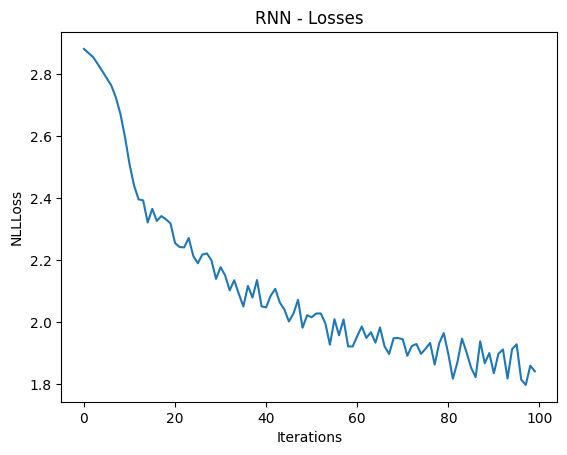

In [ ]:
print_losses(rnn_losses, 'RNN - Losses')

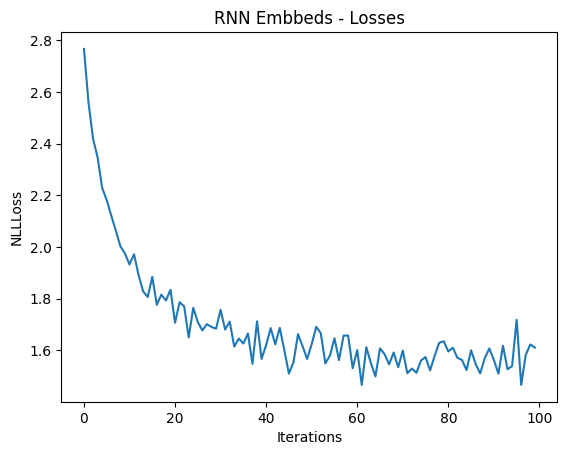

In [ ]:
print_losses(rnn_embeds_losses, 'RNN Embbeds - Losses')

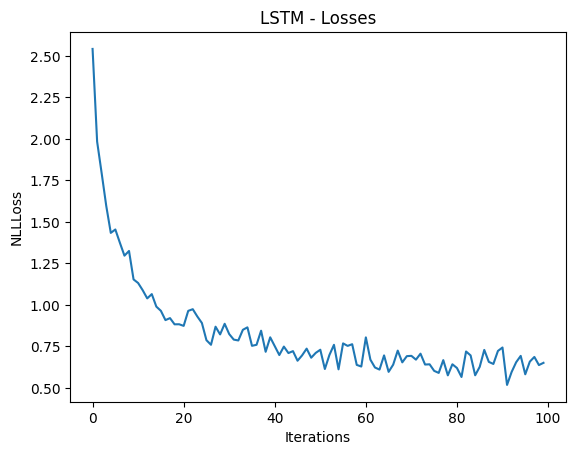

In [41]:
print_losses(lstm_losses, 'LSTM - Losses')

In [ ]:
# Just return an output given a line
def evaluate(line_tensor, model):
    hidden = model.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = model(line_tensor[i], hidden)

    return output

def create_confusion_matrix(model):
  # Keep track of correct guesses in a confusion matrix
  confusion = torch.zeros(n_categories, n_categories)
  n_confusion = 10000

  # Go through a bunch of examples and record which are correctly guessed
  for i in range(n_confusion):
      category, line, category_tensor, line_tensor = randomTrainingExample(model.type_layer)
      output = evaluate(line_tensor, model)
      guess, guess_i = categoryFromOutput(output)
      category_i = all_categories.index(category)
      confusion[category_i][guess_i] += 1

  # Normalize by dividing every row by its sum
  for i in range(n_categories):
      confusion[i] = confusion[i] / confusion[i].sum()

  # Set up plot
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(confusion.numpy())
  fig.colorbar(cax)

  # Set up axes
  ax.set_xticklabels([''] + all_categories, rotation=90)
  ax.set_yticklabels([''] + all_categories)

  # Force label at every tick
  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  # sphinx_gallery_thumbnail_number = 2
  plt.show()

<ipython-input-30-c298c41aaae2>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-30-c298c41aaae2>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


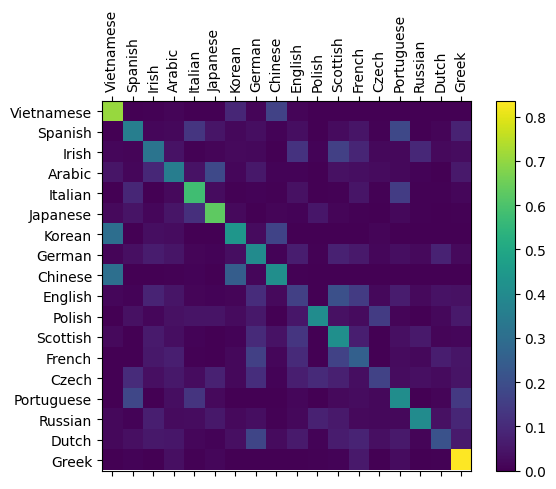

In [ ]:
create_confusion_matrix(rnn)

<ipython-input-30-c298c41aaae2>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-30-c298c41aaae2>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


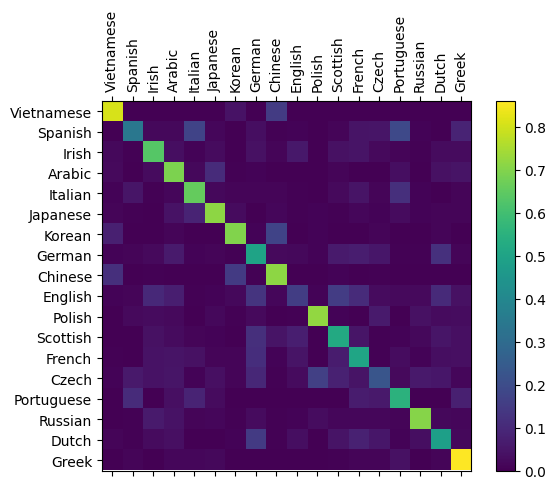

In [ ]:
create_confusion_matrix(rnn_embeds)

<ipython-input-30-c298c41aaae2>:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-30-c298c41aaae2>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


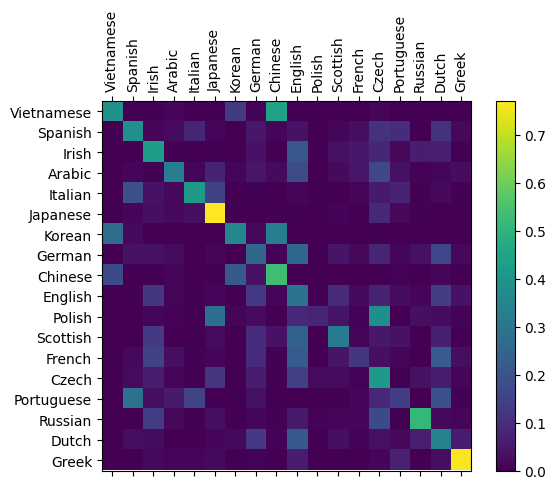

In [ ]:
create_confusion_matrix(lstm)

# Question 6
Make a function to extract the embedding and visualise in the 2D space with the color w.r.t. the Language class. Feel free to modify the `get_embeddings()` function to return what you think could be useful for the plotting. Let's use also the cosine similarity between the embeddings to see if the embedding has a sense.

In [ ]:
def getTrainingSample(word, model):
    # create a long tensor with the index of the language
    if model.type_layer == 'linear': word_tensor = wordToOneHotTensor(word)
    else: word_tensor = wordToEmbedding(word)
    return word_tensor

In [ ]:
name_to_lang = {}
for lang, list_names in category_words.items():
  for name in list_names:
    name_to_lang[name] = lang
len(name_to_lang)

17458

In [ ]:
def get_embedding(name_to_lang: dict, model):

  #if model.__class__.__name__ == 'RNN': hiddens = torch.matmul(model.i2h.weight.cpu().detach().T[:n_letters, :], model.h2o.weight.cpu().detach().T)
  #elif model.__class__.__name__  == 'RNN_mb': hiddens = torch.matmul(model.i2h.weight.cpu().detach().T[:n_letters, :], model.h2o.weight.cpu().detach().T)
  #else: pass

  hiddens, words, languages = np.empty((0,128)), list(name_to_lang.keys()), list(name_to_lang.values())

  rnn.eval()  # Set the model in evaluation mode

  # Extract hidden states from your dataset
  # Assuming you have a dataset of sequences, you can iterate over them and collect the hidden states

  # Iterate over your dataset and extract hidden states
  for name, _ in name_to_lang.items():
      hidden = rnn.initHidden()

      tensor_name = getTrainingSample(name, model)

      #sequence_hidden_states = np.empty((0, 128))

      for i in range(tensor_name.size(0)):

          with torch.no_grad():
            _, hidden = model(tensor_name[i], hidden)
            #if model.__class__.__name__ == "LSTM": output = model.log_softmax(output)
            #sequence_hidden_states.append(hidden.squeeze().numpy())
            #if not torch.all(hidden == 0):
              #print(hidden.shape)
              #print(sequence_hidden_states.size, hidden.numpy().shape)
            #sequence_hidden_states = np.vstack((sequence_hidden_states, hidden.numpy()))



      #print(sequence_hidden_states.shape)

      #hiddens.append(sequence_hidden_states)
      #print(np.sum(sequence_hidden_states, axis=0).shape)
      hiddens = np.vstack((hiddens, hidden))

  # Convert the list of hidden states to a NumPy array


  return hiddens, words, languages

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity


def print_embeddings(model, indices, name_to_lang):
  hiddens, words, languages = get_embedding(name_to_lang, rnn)

  colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'white', 'gray', 'orange', 'purple', 'brown', 'pink', 'teal', 'olive', 'indigo', 'violet', 'gold']

  tsne = TSNE()
  #embed_tsne = tsne.fit_transform(hiddens.squeeze()[:,:])
  embed_tsne = tsne.fit_transform(hiddens.squeeze()[indices,:])

  fig, ax = plt.subplots(figsize=(12, 12))
  for i, val in enumerate(indices):
      key_index = list(category_words.keys()).index(languages[val])

      plt.scatter(*embed_tsne[i, :], color=colors[key_index])
      plt.annotate(words[val]+' ('+languages[val]+')', (embed_tsne[i, 0], embed_tsne[i, 1]), alpha=0.7)

  plt.show()
  sim = cosine_similarity(hiddens)
  np.fill_diagonal(sim, -1.0)
  return sim

In [ ]:
viz_words = 4000
indices = np.random.choice(len(name_to_lang), viz_words)

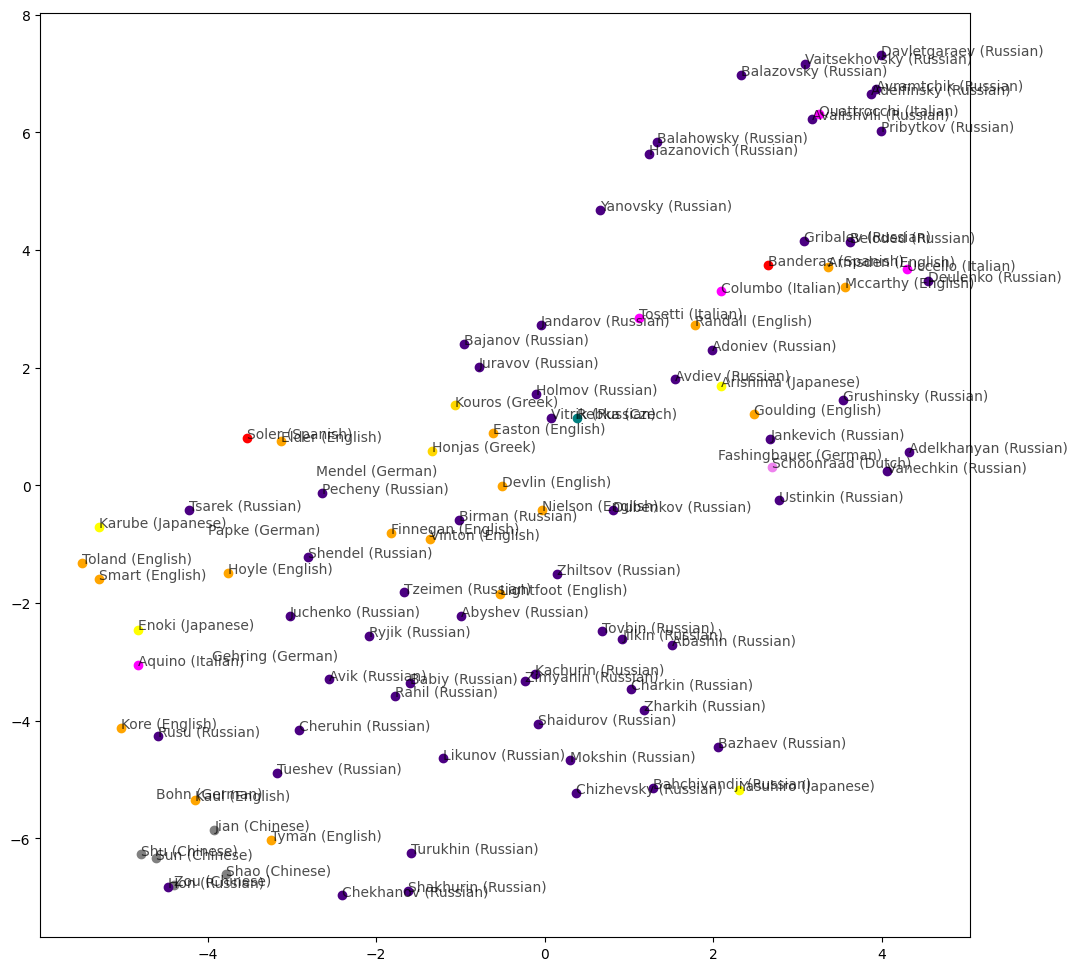

In [ ]:
sim_rnn = print_embeddings(rnn, indices, name_to_lang)

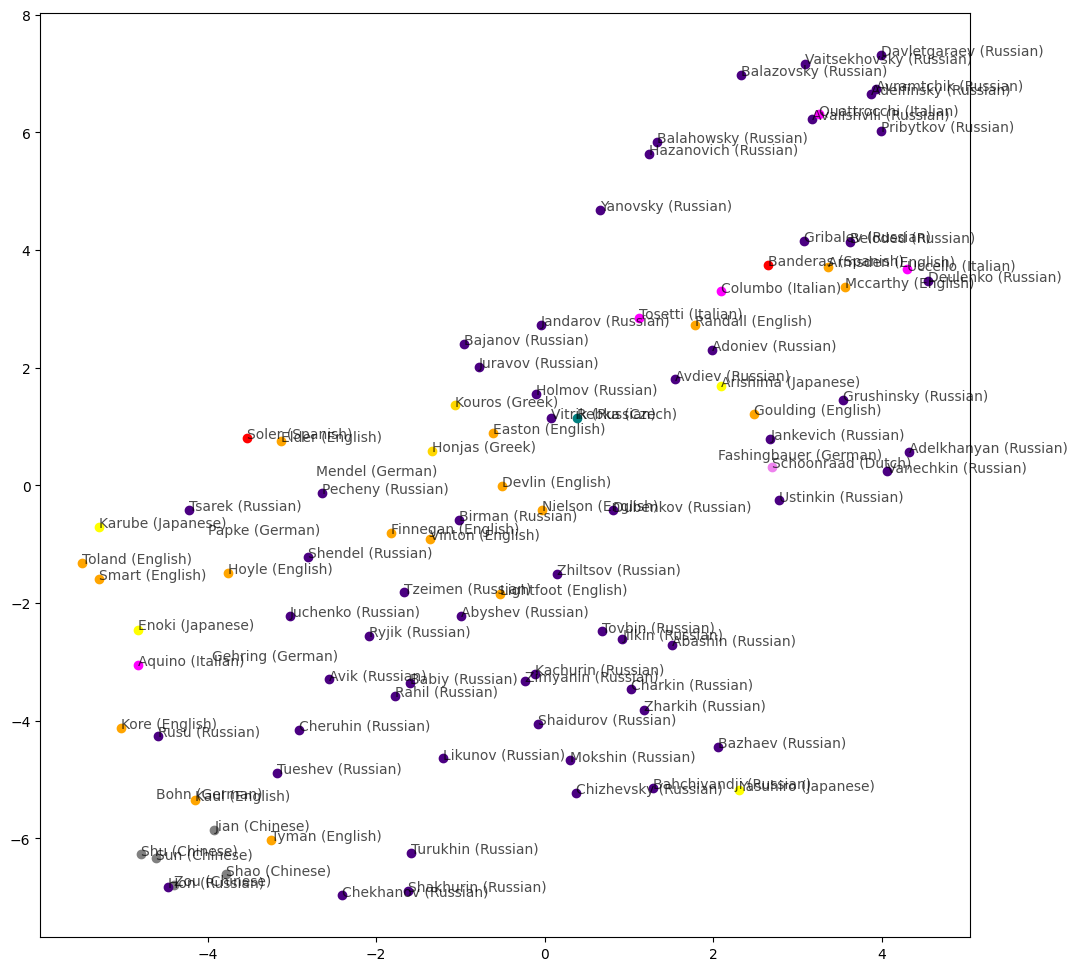

In [ ]:
sim_rnn_embeds = print_embeddings(rnn_embeds, indices, name_to_lang)

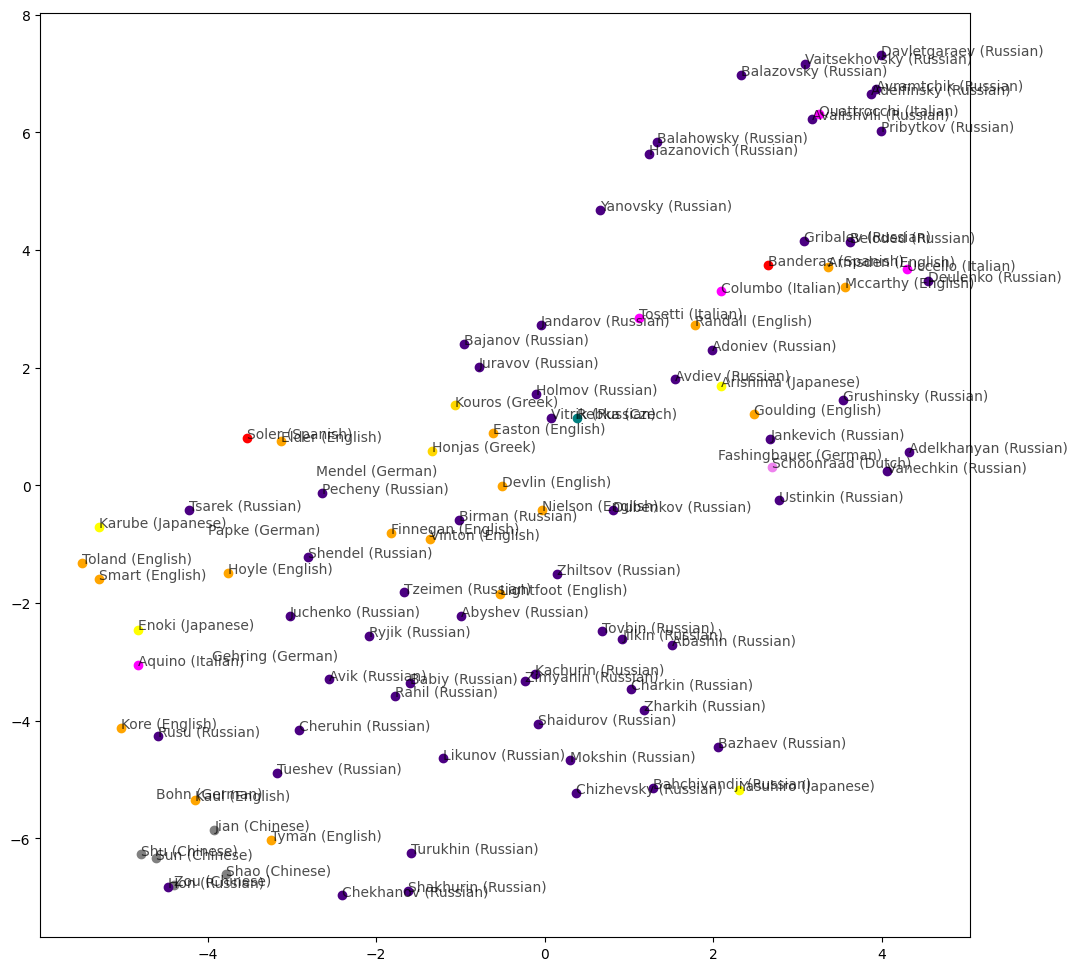

In [ ]:
sim_lstm = print_embeddings(lstm, indices, name_to_lang)

In [ ]:
def get_names_similarity(embedds_similarity, n_words, top_k):
  dict_to_return = {}
  range_embedds = range(len(embedds_similarity))
  idx_random_names = random.sample(range_embedds, n_words)
  keys = list(name_to_lang.keys())

  for idx_name in idx_random_names:
    name = keys[idx_name]

    most_similar_words_idx = np.flip(np.argsort(embedds_similarity[idx_name]))[:top_k]
    most_similar_words_str = [keys[idx] for idx in most_similar_words_idx]
    most_similar_words_lan = [name_to_lang[keys[idx]] for idx in most_similar_words_idx]
    most_similar_words_sim = [embedds_similarity[idx_name, idx] for idx in most_similar_words_idx]

    dict_to_return[idx_name] = most_similar_words_idx

    print(f'Most similar name for "{name} - ({name_to_lang[name]})" are:\t{most_similar_words_str}')
    print(f'With corresponding languages:\t{most_similar_words_lan}')
    print(f'With corresponding indices:\t{most_similar_words_idx}')
    print(f'With corresponding Embedding Cosine Similarity of:\t{most_similar_words_sim}\n')

  return dict_to_return

In [ ]:
_ = get_names_similarity(sim_rnn, 5, 5)

Most similar name for "Katsukawa - (Japanese)" are:	['Hosokawa', 'Hosokaya', 'Matsukata', 'Miksatkova', 'Sasakawa']
With corresponding languages:	['Japanese', 'Japanese', 'Japanese', 'Czech', 'Japanese']
With corresponding indices:	[1555 1556 1827 7476 2066]
With corresponding Embedding Cosine Similarity of:	[0.9862339057262327, 0.9835696317752403, 0.9819870492073317, 0.978086107260283, 0.9724021374970893]

Most similar name for "Matthams - (English)" are:	['Abrahams', 'Vilyams', 'Althaus', 'Baiguloff', 'Wagstaff']
With corresponding languages:	['English', 'Russian', 'German', 'Russian', 'English']
With corresponding indices:	[ 3360 16075  2459  8967  6659]
With corresponding Embedding Cosine Similarity of:	[0.9743823192564898, 0.9694764327536713, 0.9639913787124761, 0.960708291883866, 0.9597003041692975]

Most similar name for "Lutkovsky - (Russian)" are:	['Jurkovsky', 'Harkovsky', 'Tsenkovsky', 'Vakulovsky', 'Kachanovsky']
With corresponding languages:	['Russian', 'Russian', 'Russian

In [ ]:
_ = get_names_similarity(sim_rnn_embeds, 5, 5)

Most similar name for "Awsyuk - (Russian)" are:	['Juzvyuk', 'Basyuk', 'Babyuk', 'Vasyuk', 'Yuzvyuk']
With corresponding languages:	['Russian', 'Russian', 'Russian', 'Russian', 'Russian']
With corresponding indices:	[12334  9263  8773 15887 16541]
With corresponding Embedding Cosine Similarity of:	[0.9679892594941191, 0.9626058167981022, 0.9621248478921439, 0.9614826821509874, 0.9597861440815855]

Most similar name for "Abrasimov - (Russian)" are:	['Mursalimov', 'Abrosimov', 'Marfusalov', 'Abjalilov', 'Baiborodov']
With corresponding languages:	['Russian', 'Russian', 'Russian', 'Russian', 'Russian']
With corresponding indices:	[13616  7916 13046  7848  8939]
With corresponding Embedding Cosine Similarity of:	[0.9977167803112353, 0.9955533434961957, 0.9954513464320613, 0.9949119917320302, 0.9942938587795261]

Most similar name for "Pokhmel'Nyh - (Russian)" are:	['Vakulenchuk', 'Bahtchivandzhi', 'Zhelokhovtsev', 'Jakovchenko', 'Ladyzhensky']
With corresponding languages:	['Russian', 'Russ

In [ ]:
_ = get_names_similarity(sim_lstm, 5, 5)

Most similar name for "Frusher - (English)" are:	['Keffler', 'Geisler', 'Messner', 'Snijder', 'Oursler']
With corresponding languages:	['English', 'German', 'German', 'Dutch', 'German']
With corresponding indices:	[ 5061  2627  2869 17252  2892]
With corresponding Embedding Cosine Similarity of:	[0.9793872136197636, 0.9793070367869247, 0.9765384378027754, 0.9760075962498024, 0.9758313820154828]

Most similar name for "Meadows - (English)" are:	['Albats', 'Abrams', 'Abitoff', 'Romans', 'Abaloff']
With corresponding languages:	['Russian', 'English', 'Russian', 'English', 'Russian']
With corresponding indices:	[8193 3361 7845 6149 7753]
With corresponding Embedding Cosine Similarity of:	[0.978386842974134, 0.9779882403884156, 0.9763596074055702, 0.9747739522380793, 0.9734751323895132]

Most similar name for "Bagaturiya - (Russian)" are:	['Urogataya', 'Abakeliya', 'Havlatova', 'Horowitz', 'Kartoziya']
With corresponding languages:	['Japanese', 'Russian', 'Czech', 'German', 'Russian']
With 